In [1]:
import pandas as pd
import os
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
from torchvision import datasets, transforms, models
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch import Tensor
import torchvision
from PIL import Image
from torchvision import datasets, transforms, models
data = pd.read_csv('./aihub_data/AIhub.csv')

/home/seojungin/anaconda3/envs/ser/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
filename = './aihub_data/5e2ac6f85807b852d9e01ffe.wav'
data, rate = librosa.load(filename, sr = 22050)
print('sample rate : {}'.format(rate))
print( f'data : [ type : {type( data )}, shape : {data.shape}, \
         len : {len( data )}' )

sample rate : 22050
data : [ type : <class 'numpy.ndarray'>, shape : (142061,),          len : 142061


In [8]:
duration = librosa.get_duration( data, rate )

print('Duration : {}'.format(duration))

Duration : 6.442675736961451


/tmp/ipykernel_5615/2135236639.py:1: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00014085 -0.00013442
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration( data, rate )


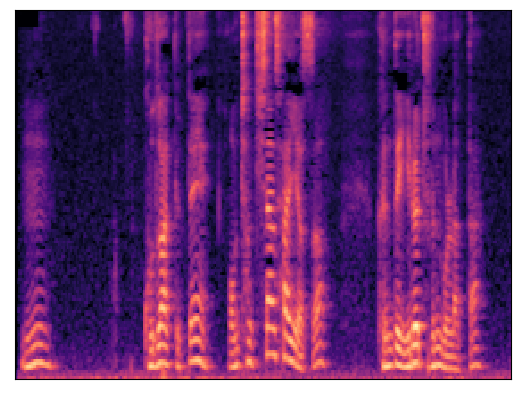

In [9]:
# y, sr = librosa.load(librosa.util.example_audio_file()) # your file
S = librosa.feature.melspectrogram(y=data, sr=rate, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), fmax=8000)
plt.savefig('mel2.jpg')

In [10]:
mylist_1= os.listdir('./aihub_data/')
type(mylist_1)
mylist=[]
for item in mylist_1:
    if item[-3:]=='wav':
        mylist.append(item)
df = pd.read_csv('./aihub_data/AIhub.csv')
df

,path,emotion
0,./4y1/5e367ec8ee8206179943c051.wav,angry
1,./4y1/5e37d20fc8c25f16cd145708.wav,angry
2,./4y1/5e36610e7995ef170fc0e868.wav,angry
3,./4y1/5e41317c0b3f160367c2075c.wav,angry
4,./4y1/5e426f780b3f160367c2097d.wav,angry
...,...,...
2190,./5y2/5f7124ddf8fac448cc0a6229.wav,sadness
2191,./4y1/5e33ce7b5807b852d9e0580f.wav,sadness
2192,./4y1/5e43a429189842034d9f77a7.wav,sadness
2193,./4y1/5e44f7f0f2fe7a3b1d544784.wav,sadness


In [12]:
X, rate = librosa.load('./aihub_data/'+df['path'][0][6:], sr = 22050)

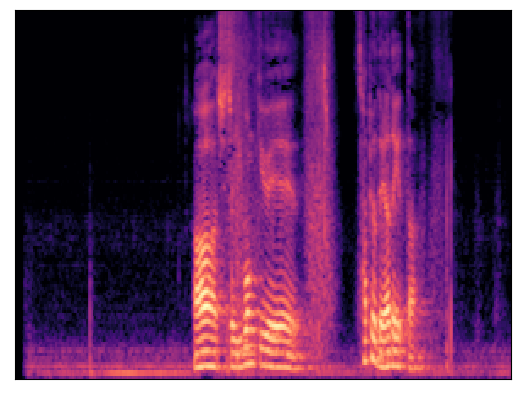

In [13]:
S = librosa.feature.melspectrogram(y=X, sr=rate, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), fmax=8000)
plt.savefig('{}.jpg'.format(1+1))

In [14]:
class aihub_dataset():
    def __init__(self, dataframe, frame_length = 0.025, frame_stride = 0.010):
        self.dataframe = dataframe
        self.frame_length = frame_length
        self.frame_stride = frame_stride

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        audio_path = self.dataframe['path'][index]
        X, sample_rate = librosa.load('./aihub_data/'+audio_path[6:], sr = 22050)
        
        sample_rate = sample_rate
        input_nfft = int(round(sample_rate*self.frame_length))
        input_stride = int(round(sample_rate*self.frame_stride))

        S = librosa.feature.melspectrogram(y=X, n_mels=64, n_fft = input_nfft, hop_length = input_stride)
        P = librosa.power_to_db(S, ref=np.max)
        df = pd.read_csv('./aihub_data/AIhub.csv')

        # get label

        if audio_path[-3:] == 'wav':
            if df['emotion'][index] == 'angry':
                label = 0
            elif df['emotion'][index] == 'neutral':
                label = 1
            elif df['emotion'][index] == 'sadness':
                label = 2
            elif df['emotion'][index] == 'happiness':
                label = 3
        else:
            label=None

        return P, label




In [15]:
train_size = int(0.7*len(df))
val_size = int(0.2*len(df))
test_size = int(len(df) - train_size - val_size)
train_set, val_set, test_set = torch.utils.data.random_split(aihub_dataset(df), [train_size, val_size, test_size])

print(train_size)
print(val_size)
print(test_size)

1536
439
220


In [21]:
# spec2img
def getimg(dataset,feature):
        img_path=[]
        labels=[]
        for i in range(len(dataset)):
                fig = plt.figure()
                ax = fig.add_subplot(111)
                p = librosa.display.specshow(dataset[i][0],ax=ax, sr=16000, hop_length=int(round(16000*0.025)), x_axis='time',y_axis='linear')
                extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

                fig.savefig('./aihub_img/{}_{}_{}.jpg'.format(dataset[i][1], i, feature), bbox_inches = extent)
                img_path.append('./aihub_img/{}_{}_{}.jpg'.format(dataset[i][1], i, feature))
                labels.append(dataset[i][1])
                plt.ioff()
                plt.close()
        return img_path , labels


In [22]:
train_path , train_labels = getimg(train_set,'train')
val_path , val_labels = getimg(val_set,'val')
test_path , test_labels = getimg(test_set,'test')

In [10]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
                                                           

In [6]:
class img2tensor():
    def __init__(self,data_path,labels,transforms):
        self.data_path = data_path
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.data_path)

        
    def __getitem__(self, index):
        img_path = self.data_path[index]
        image = Image.open(img_path)
        I = train_transforms(image)
        label = self.labels[index]

        return I, label
        
        

In [25]:
# set batch_size
batch_size = 16
# dataloader
train_dataloader = torch.utils.data.DataLoader(img2tensor(train_path,train_labels,train_transforms), batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(img2tensor(val_path,val_labels,test_transforms), batch_size=batch_size, shuffle=False)
dataloaders_dict ={'train':train_dataloader, 'val': val_dataloader}
# test
batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([16, 3, 224, 224])
tensor([1, 1, 0, 3, 1, 1, 3, 1, 0, 1, 3, 3, 1, 2, 0, 0])


In [29]:
model = torchvision.models.densenet121(pretrained=False)
model.to(torch.device('cuda'))
model.classifier = nn.Linear(in_features=1024, out_features=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters() ,lr=0.00001, weight_decay=1e-6, momentum=0.9)
model.train()

/home/kist/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kist/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [30]:
def train(net, dataloader, criterion, optimizer, num_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)
    torch.backends.cudnn.benchmark = True

    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1,num_epochs))
        print('-------------------------------')

        for phase in ['train','val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            epoch_loss = 0.0
            epoch_corrects = 0

            if (epoch == 0) and(phase == 'train'):
                continue
            for inputs, labels in tqdm(dataloader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs,1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() *inputs.size(0)

                    epoch_corrects += torch.sum(preds == labels.data)

                    epoch_loss = epoch_loss / len(dataloader[phase].dataset)
                    epoch_acc = epoch_corrects.double() / len(dataloader[phase].dataset)


            print('{} Loss: {:.4f} ACC {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
                

In [31]:
train(model, dataloaders_dict, criterion,optimizer, num_epochs=200)

cuda:0
Epoch 1/200
-------------------------------


  0%|          | 0/28 [01:37<?, ?it/s]


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# save weight
save_path = './saved_models/DenseNet121_img_aihub+augmentaion.pth'
torch.save(model.state_dict(),save_path)

In [3]:
# load weight
load_path = './pth/DenseNet121_img_aihub.pth'
load_weights = torch.load(load_path, map_location={'cuda:0': 'cpu'})
model = torchvision.models.densenet121(pretrained=True)
# first_conv_layer = [nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)]
# first_conv_layer.extend(list(model.features))  
# model.features= nn.Sequential(*first_conv_layer )  
model.classifier = nn.Linear(in_features=1024, out_features=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters() ,lr=0.00001, weight_decay=1e-6, momentum=0.9)
model.eval()
model.load_state_dict(load_weights)

<All keys matched successfully>

In [4]:
class Predictor(object):
    def __init__(self, model, device ='cpu',  fp16=False ):
        self.model = model
        
        self.cls_name = {0:'angry', 1:'happy', 2:'sad', 3:'neutral'}
        self.device = device
        

    def predict(self, audio):
        
        audio_info = audio
        
        outputs = self.model(audio_info)
        probability = torch.softmax(outputs,1)
        probability = probability.squeeze()
        proba, idx = torch.max(probability, dim=0)
        emo_proba = proba.item()
        print(emo_proba)
        idx = idx.item()
        emo_label = self.cls_name[idx]
        print(emo_label)
        return emo_label


In [7]:
predictor = Predictor(modelb)
device='cpu'
a=[]
b=[]
for i in range(len(img2tensor(test_path,test_labels,test_transforms))):
    a.append(predictor.predict(img2tensor(test_path,test_labels,test_transforms)[i][0].unsqueeze(0)))
    b.append(img2tensor(test_path,test_labels,test_transforms)[i][1])

NameError: name 'test_path' is not defined

In [12]:
predictor = Predictor(model)
device = 'cpu'
predictor.predict(img2tensor('./aihub_img/0_0_test.jpg','angry',test_transforms))

TypeError: conv2d() received an invalid combination of arguments - got (img2tensor, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!img2tensor!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!img2tensor!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
